In [ ]:
#@title Install prerequsite: you may have to do Runtime -> Restart runtime after the installation

!pip install --upgrade pip
!pip install --upgrade setuptools wheel
!pip install --upgrade "mxnet<2.0.0"
!pip install autogluon

In [ ]:
import autogluon

In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set up data folder
from pathlib import Path

# Change this to where you put your hw2 files
DATA = Path("/content/drive/My Drive/project")

# Project part 1 

## Reclassifying Mutations



First the existing mutation files from the paper were loaded. The mutations from the files were combined a kept seperate by gene. The total mutations for each type of gene found in this analysis match the mutations statistics record in the meta files from the paper. 

In [ ]:
import pandas as pd
snvsfile = DATA / "snvs.txt"
snvs = pd.read_csv(snvsfile, sep="\t", comment="#")
snvs = snvs[['Gene', 'Sample_ID']]
snvs = snvs.dropna()

In [ ]:
import pandas as pd
indelsfile = DATA / "indels.txt"
indels = pd.read_csv(indelsfile, sep="\t", comment="#")
indels = indels[['Gene', 'Sample_ID']]
indels = indels.dropna()

In [ ]:
groupedsnvs = snvs.groupby(by=['Gene']).count()
groupedsnvs = groupedsnvs.sort_values(by = ["Sample_ID"], ascending=False)
groupedsnvs.head()

,Sample_ID
Gene,
SMARCB1,5
KRT39,2
MUC16,2
OR4C6,2
ARMCX4,2


In [ ]:
groupedindels = indels.groupby(by=['Gene']).count()
groupedindels = groupedindels.sort_values(by = ["Sample_ID"], ascending=False)
groupedindels.head()

,Sample_ID
Gene,
SMARCB1,2
ANK2,1
AUTS2,1
ZBTB48,1
TBX15,1


In [ ]:
concat = pd.concat([snvs, indels])

In [ ]:
count = concat.groupby(by='Gene')
count = count.describe()
count = count['Sample_ID']
count = count.sort_values(by ='unique', ascending=False)
count = count[['unique']]
count.head()

,unique
Gene,
SMARCB1,7
MUC16,2
ARMCX4,2
PPARGC1A,1
RAB11FIP2,1


In [ ]:
count['snvs'] = groupedsnvs.Sample_ID
count['indel'] = groupedindels.Sample_ID
summary = count.fillna(0)
summary = summary.astype(int)
summary

,unique,snvs,indel
Gene,,,
SMARCB1,7,5,2
MUC16,2,2,0
ARMCX4,2,2,0
PPARGC1A,1,1,0
RAB11FIP2,1,1,0
...,...,...,...
IFIT3,1,1,0
IL36B,1,0,1
ISL2,1,1,0


# Project Part 2

## Machine Learning

The paper uses methylation data to divide the atrt tumors into three seperate subcatagories. The gene expression data contains similar data but unlike the methylation data it is not specific to a location. We started by loading the gene expression and methylation data for 49 cases from the 180 atrt patients in the paper. The subtype labels from the paper are then matched with these 49 samples by sample name. The 49 samples are now split into 3 groups and can be used in a multiclass training method by autogluon. The data was split into 40 training cases and 9 test cases, 3 from each class. 

In [ ]:
import pandas as pd

gefile = DATA / "GSE70678_matrix.txt"
methfile = DATA / "GSE70460_series_matrix.txt.gz"

ge = pd.read_csv(gefile, sep="\t", na_values="unknown", index_col=0)
meth = pd.read_csv(methfile, sep="\t", na_values="unknown", index_col=0, header= 64)
gemeta = ge.head(36)
ge.columns = ge.iloc[35]
ge = ge.iloc[36:-1 ,:]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
gemeta.head()

,dkfz_ATRT_159,dkfz_ATRT_17,dkfz_ATRT_25,dkfz_ATRT_173,dkfz_ATRT_151,dkfz_ATRT_171,dkfz_ATRT_152,dkfz_ATRT_172,dkfz_ATRT_153,dkfz_ATRT_86,dkfz_ATRT_10,dkfz_ATRT_154,dkfz_ATRT_30,dkfz_ATRT_36,dkfz_ATRT_11,dkfz_ATRT_12,dkfz_ATRT_41,dkfz_ATRT_43,dkfz_ATRT_164,dkfz_ATRT_16,dkfz_ATRT_6,dkfz_ATRT_160,dkfz_ATRT_7,dkfz_ATRT_48,dkfz_ATRT_49,dkfz_ATRT_51,dkfz_ATRT_47,dkfz_ATRT_46,dkfz_ATRT_101,dkfz_ATRT_157,dkfz_ATRT_155,dkfz_ATRT_168,dkfz_ATRT_156,dkfz_ATRT_163,dkfz_ATRT_162,dkfz_ATRT_158,dkfz_ATRT_166,dkfz_ATRT_169,dkfz_ATRT_170,dkfz_ATRT_88,dkfz_ATRT_72,dkfz_ATRT_167,dkfz_ATRT_85,dkfz_ATRT_84,dkfz_ATRT_165,dkfz_ATRT_14,dkfz_ATRT_32,dkfz_ATRT_161,dkfz_ATRT_90
!Sample_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!Sample_geo_accession,GSM1816332,GSM1816333,GSM1816334,GSM1816335,GSM1816336,GSM1816337,GSM1816338,GSM1816339,GSM1816340,GSM1816341,GSM1816342,GSM1816343,GSM1816344,GSM1816345,GSM1816346,GSM1816347,GSM1816348,GSM1816349,GSM1816350,GSM1816351,GSM1816352,GSM1816353,GSM1816354,GSM1816355,GSM1816356,GSM1816357,GSM1816358,GSM1816359,GSM1816360,GSM1816361,GSM1816362,GSM1816363,GSM1816364,GSM1816365,GSM1816366,GSM1816367,GSM1816368,GSM1816369,GSM1816370,GSM1816371,GSM1816372,GSM1816373,GSM1816374,GSM1816375,GSM1816376,GSM1816377,GSM1816378,GSM1816379,GSM1816380
!Sample_status,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016
!Sample_submission_date,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015
!Sample_last_update_date,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018
!Sample_type,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA
!Sample_channel_count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
!Sample_source_name_ch1,Primary ATRT tumor tissue,Primary ATRT tumor 

In [ ]:
ge.head()

ID_REF,GSM1816332,GSM1816333,GSM1816334,GSM1816335,GSM1816336,GSM1816337,GSM1816338,GSM1816339,GSM1816340,GSM1816341,GSM1816342,GSM1816343,GSM1816344,GSM1816345,GSM1816346,GSM1816347,GSM1816348,GSM1816349,GSM1816350,GSM1816351,GSM1816352,GSM1816353,GSM1816354,GSM1816355,GSM1816356,GSM1816357,GSM1816358,GSM1816359,GSM1816360,GSM1816361,GSM1816362,GSM1816363,GSM1816364,GSM1816365,GSM1816366,GSM1816367,GSM1816368,GSM1816369,GSM1816370,GSM1816371,GSM1816372,GSM1816373,GSM1816374,GSM1816375,GSM1816376,GSM1816377,GSM1816378,GSM1816379,GSM1816380
!Sample_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1007_s_at,426.5,1448.6,573.1,417.5,479.6,1243.2,529.4,1151.6,1126.9,588.7,669.3,112,1207.1,641,767.2,979.7,1199.5,1098.8,378.1,416.6,590.6,826.1,1116.2,873.6,671.6,536.3,114.2,2334.8,766.3,1193.7,637.7,686.2,313,455,217,1060.9,425.1,146.1,334.2,350.8,687.5,845.7,590.6,348.7,1382.3,567.2,1284.5,1014.9,605.3
1053_at,95.9,173.3,75.7,57.7,160.9,141,188.5,126.1,122.6,107.8,163.9,120.6,118.9,177.4,154.9,112.3,97.9,120.3,181.9,156.3,100,125.5,154.1,155.1,103.2,180.1,236.3,81,112.4,154.9,141.2,230.8,127.3,158.8,181.2,187.2,140.2,132.6,81.8,147.8,75.3,209.3,197.1,189.5,86.5,171.7,145.9,157,168.4
117_at,28.3,18.6,42.7,169.2,15.7,17.2,21.4,70.2,54.4,795.3,30.9,26.6,12.8,17,17.2,38,28.4,95.8,74.8,49.3,44,198.2,23.1,34.8,37.4,12.6,83.5,43.7,75.1,23.5,22.5,27.1,37.7,46.3,26.9,9.7,65.4,69.2,34.3,89.5,28.9,18.5,31.7,21.9,102.9,49.7,1333.4,18.8,63
121_at,94.3,45.3,57.7,72,55.1,63.3,80.4,36.3,68.6,91,95.9,133.8,134.6,100,69.5,91.4,79.2,55.5,71.9,61.6,61.7,98.8,52.1,92.9,140.6,125.4,86.2,61.4,61.2,120.5,72.6,78,88.2,93.9,64.1,66.9,101.1,124.1,143.5,101.4,77.6,121.2,80.9,68.3,132,118.7,64.3,60.2,77.8
1255_g_at,2.5,0.7,5.7,58.4,3.1,2.4,3.2,10.5,7.3,7.5,6.8,1.1,5.2,6.9,3.5,3.4,1.4,10.9,12.5,18.6,2.4,21.5,0.8,7.1,8.7,4,7.8,6.8,1.9,8.4,11.2,4.4,4.5,8.2,1.5,6.5,2.4,9.5,4.2,7.4,8.3,8.4,4.3,1.8,6.9,1.5,1.3,37.8,9.2


In [ ]:
meth.head()

,GSM1755170,GSM1755171,GSM1755172,GSM1755173,GSM1755174,GSM1755175,GSM1755176,GSM1755177,GSM1755178,GSM1755179,GSM1755180,GSM1755181,GSM1755182,GSM1755183,GSM1755184,GSM1755185,GSM1755186,GSM1755187,GSM1755188,GSM1755189,GSM1755190,GSM1755191,GSM1755192,GSM1755193,GSM1755194,GSM1755195,GSM1755196,GSM1755197,GSM1755198,GSM1755199,GSM1755200,GSM1755201,GSM1755202,GSM1755203,GSM1755204,GSM1755205,GSM1755206,GSM1755208,GSM1755209,GSM1755210,...,GSM1755367,GSM1755371,GSM1755375,GSM1755378,GSM1755382,GSM1755385,GSM1755388,GSM1755392,GSM1755395,GSM2051672,GSM2051673,GSM2051674,GSM2051675,GSM2051676,GSM2051677,GSM2051678,GSM2051679,GSM2051680,GSM2051681,GSM2051682,GSM2051683,GSM2051684,GSM2051685,GSM2051686,GSM2051687,GSM2051688,GSM2051689,GSM2051690,GSM2051691,GSM2051692,GSM2051693,GSM2051694,GSM2051695,GSM2051696,GSM2051697,GSM2051698,GSM2051699,GSM2051700,GSM2051701,GSM2051702
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.233639,0.707772,0.251903,0.526724,0.404274,0.356997,0.444767,0.188338,0.689528,0.222346,0.748297,0.494161,0.428071,0.283786,0.743197,0.302302,0.437280,0.315523,0.591644,0.351332,0.408740,0.249594,0.240342,0.170581,0.317655,0.244369,0.573248,0.314415,0.329547,0.652745,0.740240,0.370276,0.391482,0.303231,0.164043,0.114542,0.262227,0.676064,0.326391,0.341752,...,0.470345,0.442620,0.549346,0.389695,0.297349,0.516124,0.384618,0.523748,0.204516,0.577293,0.330351,0.271943,0.390737,0.589534,0.145170,0.265167,0.298249,0.316445,0.340578,0.394026,0.512050,0.276085,0.414950,0.542832,0.162054,0.462029,0.244735,0.332264,0.393462,0.569178,0.209321,0.352109,0.439519,0.256184,0.186200,0.211489,0.148386,0.293506,0.426848,0.375697
cg00000108,0.938803,0.911581,0.929206,0.935562,0.941001,0.925437,0.913178,0.917131,0.953745,0.963604,0.930982,0.949970,0.941192,0.908703,0.935924,0.936123,0.961198,0.842026,0.949979,0.893223,0.931049,0.947004,0.907066,0.940768,0.935493,0.929884,0.915023,0.950989,0.955798,0.925292,0.937417,0.936939,0.936586,0.924737,0.883539,0.951436,0.921340,0.915088,0.889984,0.920692,...,0.915920,0.855734,0.835532,0.870266,0.880080,0.851440,0.938475,0.901274,0.940875,0.855938,0.821875,0.891613,0.879165,0.804980,0.855547,0.862085,0.903575,0.870697,0.890521,0.900931,0.886325,0.880761,0.876552,0.852082,0.871461,0.855256,0.782079,0.862102,0.862107,0.832371,0.879776,0.752832,0.839864,0.733557,0.868390,0.787937,0.864105,0.788029,0.828619,0.825274
cg00000109,0.883326,0.877838,0.731915,0.752427,0.796499,0.887018,0.838659,0.850539,0.893031,0.906258,0.801748,0.429852,0.833911,0.818169,0.537447,0.870020,0.888209,0.819853,0.631496,0.604464,0.849264,0.841755,0.882378,0.902550,0.881787,0.717837,0.738306,0.868691,0.610745,0.916624,0.628656,0.873302,0.891642,0.853650,0.583921,0.856182,0.912622,0.781826,0.813454,0.899448,...,0.548857,0.808218,0.559361,0.611600,0.641877,0.822538,0.583476,0.787079,0.870045,0.735572,0.641026,0.596404,0.829746,0.535771,0.789474,0.830111,0.824748,0.500782,0.832552,0.875909,0.787627,0.811469,0.815374,0.833258,0.845466,0.826607,0.692812,0.481772,0.824240,0.822971,0.816227,0.590704,0.834401,0.740834,0.682739,0.705098,0.810355,0.598137,0.551450,0.750243
cg00000165,0.528943,0.132206,0.670318,0.205442,0.424001,0.151361,0.371850,0.673996,0.858881,0.517007,0.338881,0.530169,0.123305,0.147213,0.880645,0.859784,0.093326,0.110808,0.193867,0.758933,0.276771,0.696539,0.597661,0.562081,0.840610,0.106546,0.111664,0.449088,0.112873,0.543175,0.610725,0.211313,0.816915,0.809718,0.204638,0.938450,0.702455,0.448489,0.096944,0.778999,...,0.450405,0.387707,0.789935,0.567875,0.470227,0.475603,0.166931,0.218099,0.872623,0.190535,0.380332,0.103104,0.090690,0.557864,0.744303,0.470095,0.741788,0.162595,0.441244,0.101852,0.157865,0.624784,0.372658,0.713473,0.771577,0.357595,0.178367,0.183553,0.528264,0.720386,0.098405,0.452315,0.279491,0.103816,0.730732,0.237288,0.588285,0.462184,0.136910,0.552412
cg00000236,0.634338,0.744383,0.876071,0.822100,0.903711,0.909017,0.813823,0.651720,0.89

Thte meta file is loaded in here along with other variable to include in the autogluon training in case the help. 

In [ ]:
classfile = DATA / "metaandclassify.txt"
classified = pd.read_csv(classfile, sep="\t", comment="#",index_col=0)
classified = classified[['Molecular Subgroup (Consensus)','Gender (F= FeMale, M=Male)','Age at diagnosis']]
classified.head()

,Molecular Subgroup (Consensus),"Gender (F= FeMale, M=Male)",Age at diagnosis
Sample Name,,,
dkfz_ATRT_1,SHH,F,2.0
dkfz_ATRT_2,SHH,M,2.0
dkfz_ATRT_3,SHH,F,NaN
dkfz_ATRT_4,MYC,M,4.0
dkfz_ATRT_5,SHH,M,4.0


In [ ]:
meta = gemeta.transpose()
classified = classified[classified.index.isin(meta.index)]
classified.sort_index(inplace=True)
meta.sort_index(inplace=True)
meta['Class'] = classified['Molecular Subgroup (Consensus)']
meta['Age'] = classified['Age at diagnosis']
meta['Gender'] = classified['Gender (F= FeMale, M=Male)']
meta = meta.rename(columns={"!Sample_geo_accession": "SampleGeo"})
meta.rename(columns = {list(meta)[9]: 'cha1'}, inplace = True)

meta.head()

!Sample_title,SampleGeo,!Sample_status,!Sample_submission_date,!Sample_last_update_date,!Sample_type,!Sample_channel_count,!Sample_source_name_ch1,!Sample_organism_ch1,cha1,cha1,cha1,!Sample_treatment_protocol_ch1,!Sample_growth_protocol_ch1,!Sample_molecule_ch1,!Sample_extract_protocol_ch1,!Sample_label_ch1,!Sample_label_protocol_ch1,!Sample_taxid_ch1,!Sample_hyb_protocol,!Sample_scan_protocol,!Sample_description,!Sample_data_processing,!Sample_platform_id,!Sample_contact_name,!Sample_contact_email,!Sample_contact_department,!Sample_contact_institute,!Sample_contact_address,!Sample_contact_city,!Sample_contact_zip/postal_code,!Sample_contact_country,!Sample_supplementary_file,!Sample_data_row_count,!Sample_relation,!series_matrix_table_begin,ID_REF,Class,Age,Gender
dkfz_ATRT_10,GSM1816342,Public on Mar 02 2016,Jul 09 2015,Mar 13 2018,RNA,1,Primary ATRT tumor tissue,Homo sapiens,gender: F,age (years): NA,tumor location: NA,NaN,NaN,total RNA,Total RNA from biopsy samples was isolated aft...,biotin,Affymetrix protocol,9606,Affymetrix protocol,Affymetrix protocol,Gene expression data from an ATRT tumor sample,For normalization of the expression data we us...,GPL570,"Marcel,,Kool",m.kool@dkfz.de,Pediatric Neurooncology,German Cancer Research Center DKFZ,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1816...,54675,Reanalyzed by: GSE111787,NaN,GSM1816342,TYR,NaN,F
dkfz_ATRT_101,GSM1816360,Public on Mar 02 2016,Jul 09 2015,Mar 13 2018,RNA,1,Primary ATRT tumor tissue,Homo sapiens,gender: F,age (years): NA,tumor location: NA,NaN,NaN,total RNA,Total RNA from biopsy samples was isolated aft...,biotin,Affymetrix protocol,9606,Affymetrix protocol,Affymetrix protocol,Gene expression data from an ATRT tumor sample,For normalization of the expression data we us...,GPL570,"Marcel,,Kool",m.kool@dkfz.de,Pediatric Neurooncology,German Cancer Research Center DKFZ,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1816...,54675,Reanalyzed by: GSE111787,NaN,GSM1816360,TYR,NaN,F
dkfz_ATRT_11,GSM1816346,Public on Mar 02 2016,Jul 09 2015,Mar 13 2018,RNA,1,Primary ATRT tumor tissue,Homo sapiens,gender: M,age (years): 2,tumor location: Infratentorial,NaN,NaN,total RNA,Total RNA from biopsy samples was isolated aft...,biotin,Affymetrix protocol,9606,Affymetrix protocol,Affymetrix protocol,Gene expression data from an ATRT tumor sample,For normalization of the expression data we us...,GPL570,"Marcel,,Kool",m.kool@dkfz.de,Pediatric Neurooncology,German Cancer Research Center DKFZ,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1816...,54675,Reanalyzed by: GSE111787,NaN,GSM1816346,SHH,2.0,M
dkfz_ATRT_12,GSM1816347,Public on Mar 02 2016,Jul 09 2015,Mar 13 2018,RNA,1,Primary ATRT tumor tissue,Homo sapiens,gender: M,age (years): 1,tumor location: Infratentorial,NaN,NaN,total RNA,Total RNA from biopsy samples was isolated aft...,biotin,Affymetrix protocol,9606,Affymetrix protocol,Affymetrix protocol,Gene expression data from an ATRT tumor sample,For normalization of the expression data we us...,GPL570,"Marcel,,Kool",m.kool@dkfz.de,Pediatric Neurooncology,German Cancer Research Center DKFZ,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1816...,54675,Reanalyzed by: GSE111787,NaN,GSM1816347,SHH,1.0,M
dkfz_ATRT_14,GSM1816377,Public on Mar 02 2016,Jul 09 2015,Mar 13 2018,RNA,1,Primary ATRT tumor tissue,Homo sapiens,gender: NA,age (years): 2,tumor location: Infratentorial,NaN,NaN,total RNA,Total RNA from biopsy samples was isolated aft...,biotin,Affymetrix protocol,9606,Affymetrix protocol,Affymetrix protocol,Gene expression data from an ATRT tumor sample,For normalization of the expression data we us...,GPL570,"Marcel,,Kool",m.kool@dkfz.de,Pediatric Neurooncology,German Cancer Research Center DKFZ,Im Neuenheimer Feld 280,Heidelberg,69120,Germany,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1816...,5467

### Split test set

3 samples are chosen from each class of tumor to become the test dataset

In [ ]:

# pick 3 samples from each class (MYC, SHH, TYR) as test set for evaluation in the end
test_sample_id = meta.groupby("Class").apply(lambda g: g.SampleGeo.iloc[-3:])
test_sample_id

Class              
MYC    dkfz_ATRT_46    GSM1816359
       dkfz_ATRT_49    GSM1816356
       dkfz_ATRT_90    GSM1816380
SHH    dkfz_ATRT_51    GSM1816357
       dkfz_ATRT_7     GSM1816354
       dkfz_ATRT_72    GSM1816372
TYR    dkfz_ATRT_85    GSM1816374
       dkfz_ATRT_86    GSM1816341
       dkfz_ATRT_88    GSM1816371
Name: SampleGeo, dtype: object

In [ ]:
# define train and test set
meta["subset"] = "train"
meta.loc[meta.SampleGeo.isin(test_sample_id), "subset"] = "test"

In [ ]:
meta.groupby(["subset", "Class"]).SampleGeo.nunique()

subset  Class
test    MYC       3
        SHH       3
        TYR       3
train   MYC      12
        SHH      13
        TYR      15
Name: SampleGeo, dtype: int64

### Feature selection

Using the method from class we calculate the mutual information between each gene and the severity using scikit-learn's [`mutual_info_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) function. All genes are ranked and a cutoff is selected. 

In [ ]:
#=======================================================
# Your code here
# Perform feature selection using mutual_info_classif 
#=======================================================
di = {"TYR": 0, "SHH": 1,"MYC":2}
meta = meta.replace({"Class": di})
target = (meta["Class"]).astype(int)

In [ ]:
# Creating trianing and testing data. 


y_train = target[(meta.subset == "train")].values
y_test = target[(meta.subset == "test")].values
x_train = ge[meta[meta.subset == "train"].SampleGeo].transpose()
x_test = ge[meta[meta.subset == "test"].SampleGeo].transpose()

In [ ]:
from sklearn.feature_selection import mutual_info_classif


In [ ]:
midf = pd.DataFrame({
    "feature": x_train.columns,
    "mi": mutual_info_classif(x_train, y_train,)
}).sort_values("mi", ascending=False)

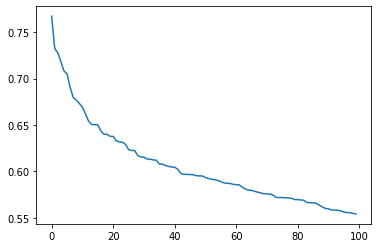

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(100), midf.mi.iloc[:100])

In [ ]:
selected_genes = midf.feature.loc[midf.mi > 0.62]
len(selected_genes)

28

### Training an ATRT classifier using AutoML

Procedures used in class were repeated here to create an AutoML model for classifying ATRT data.

In [ ]:
#===========================================================================
# Your code here
# Train a classification model using AutoGluon TabularPrediction module with
# features selected by the RandomForestClassifier
#===========================================================================

from autogluon.tabular import TabularPredictor

train_data = x_train.loc[:, selected_genes].copy()
train_data["Class"] = y_train

predictor = TabularPredictor(label="Class", path="good_quality_atrt").fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)


Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "good_quality_atrt/"
AutoGluon Version:  0.3.1
Train Data Rows:    40
Train Data Columns: 28
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11895.46 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generat

Performance scores are calculated to evaluate the model. 

In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.idxmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        #"auroc": roc_auc_score(y_true, y_pred_score[:, 1], average="weighted",
        #                       multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [ ]:

test_data = x_test.loc[:, selected_genes].copy()
y_pred_score = predictor.predict_proba(test_data).values
y_pred = predictor.predict(test_data)
y_pred
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.3333333333333333,
 'balanced_accuracy': 0.3333333333333333,
 'f1': 0.1818181818181818}

In [ ]:
y_pred_score

array([[0.02039674, 0.95528865, 0.02431464],
       [0.52641743, 0.11188054, 0.361702  ],
       [0.52641743, 0.11188054, 0.361702  ],
       [0.52641743, 0.11188054, 0.361702  ],
       [0.52641743, 0.11188054, 0.361702  ],
       [0.52641743, 0.11188054, 0.361702  ],
       [0.52641743, 0.11188054, 0.361702  ],
       [0.52641743, 0.11188054, 0.361702  ],
       [0.52641743, 0.11188054, 0.361702  ]], dtype=float32)

Now also plot the confusion matrix to show correct and incorrect predictions in the test set

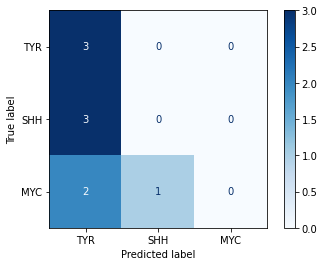

In [ ]:
#============================================================================
# Your code here
# Plot confusion matrix for the trained model
#============================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["TYR", "SHH","MYC"])
disp.plot(cmap="Blues")

The models are displayed here in a leader board to show which performed best.


In [ ]:
predictor.leaderboard()

                           model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     ExtraTreesEntr_BAG_L1_FULL      0.575       0.100577  0.760374                0.100577           0.760374            1       True         20
1     ExtraTreesGini_BAG_L1_FULL      0.575       0.101893  0.867148                0.101893           0.867148            1       True         19
2          ExtraTreesEntr_BAG_L1      0.575       0.102436  0.772450                0.102436           0.772450            1      False          8
3          ExtraTreesGini_BAG_L1      0.575       0.114720  0.764169                0.114720           0.764169            1      False          7
4            WeightedEnsemble_L2      0.575       0.115330  1.050670                0.000610           0.286501            2      False         12
5                CatBoost_BAG_L1      0.550       0.050498  2.939611                0.050498           2.939611       

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr_BAG_L1_FULL,0.575,0.100577,0.760374,0.100577,0.760374,1,True,20
1,ExtraTreesGini_BAG_L1_FULL,0.575,0.101893,0.867148,0.101893,0.867148,1,True,19
2,ExtraTreesEntr_BAG_L1,0.575,0.102436,0.772450,0.102436,0.772450,1,False,8
3,ExtraTreesGini_BAG_L1,0.575,0.114720,0.764169,0.114720,0.764169,1,False,7
4,WeightedEnsemble_L2,0.575,0.115330,1.050670,0.000610,0.286501,2,False,12
5,CatBoost_BAG_L1,0.550,0.050498,2.939611,0.050498,2.939611,1,False,6
6,RandomForestEntr_BAG_L1_FULL,0.550,0.101501,0.863880,0.101501,0.863880,1,True,17
7,RandomForestGini_BAG_L1_FULL,0.550,0.102737,0.861766,0.102737,0.861766,1,True,16
8,RandomForestGini_BAG_L1,0.550,0.113915,0.923613,0.113915,0.923613,1,False,4
9,RandomForestEntr_BAG_L1,0.550,0.117148,0.871294,0.117148,0.871294,1,False,5


In [ ]:
featimp = predictor.feature_importance(train_data, num_shuffle_sets=10)
featimp[featimp.importance > 0].sort_values("p_value")

Computing feature importance via permutation shuffling for 28 features using 40 rows with 10 shuffle sets...
	43.76s	= Expected runtime (4.38s per shuffle set)
	2.68s	= Actual runtime (Completed 10 of 10 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
1557275_a_at,0.1000,0.023570,1.480476e-07,10,0.124223,0.075777
226535_at,0.1650,0.042817,3.376672e-07,10,0.209003,0.120997
241359_at,0.0875,0.033850,9.313427e-06,10,0.122287,0.052713
225877_at,0.0400,0.047434,1.288140e-02,10,0.088748,-0.008748


The best model in this dataset was the 'ExtraTreesEntr_BAG_L1_FULL' and we can see that the most important features were all the at genes, which is expected in atrt patients. 

Additional features from the meta file can be added to the analysis, but it can be seen that they are not selected and make no difference on the AutoML model. 

In [ ]:
feature_columns = [
    'Age', 'Gender'
]


In [ ]:
# Creating training and testing data. 

x_train = pd.concat([
    meta.loc[meta.subset == "train", feature_columns + ["SampleGeo"]].set_index("SampleGeo"),
    ge[meta[meta.subset == "train"].SampleGeo].transpose()
], axis=1)
y_train = target[(meta.subset == "train")].values
x_test = pd.concat([
    meta.loc[meta.subset == "test", feature_columns + ["SampleGeo"]].set_index("SampleGeo"),
    ge[meta[meta.subset == "test"].SampleGeo].transpose()
], axis=1)
y_test = target[(meta.subset == "test")].values

In [ ]:
# for categorical variable, we simply encode it as 0 for male, 1 for female
x_train["Gender"] = (x_train.Gender == "F").astype(int)
x_test["Gender"] = (x_test.Gender == "F").astype(int)

In [ ]:
# for missing data, we'll use the mean imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
x_train_mi = imputer.fit_transform(x_train)
x_test_mi = imputer.transform(x_test)

In [ ]:
midf = pd.DataFrame({
    "feature": x_train.columns,
    "mi": mutual_info_classif(x_train_mi, y_train)
}).sort_values("mi", ascending=False)

In [ ]:
plt.plot(np.arange(100), midf.mi.iloc[:100])

In [ ]:
selected_features = midf.loc[midf.mi > 0.62, "feature"]

In [ ]:
# there are no features in the metadata selected based on MI
[x for x in meta.columns if x in selected_features]

In [ ]:

from autogluon.tabular import TabularPredictor

train_data = x_train[selected_features].copy()
train_data["Class"] = y_train

predictor = TabularPredictor(
    label="Class", path="good_quality_atrt_meta"
).fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)


In [ ]:
test_data = x_test[selected_features].copy()
y_pred_score = predictor.predict_proba(test_data).values
y_pred = predictor.predict(test_data)

performance_scores(y_test, y_pred_score, y_pred)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["TYR", "SHH","MYC"])
disp.plot(cmap="Blues")

The features in the metadata did not have high enough MI with the severity and thus none of the features were selected into model training. The performance of the model remains the same given the same feature selection criteria.